In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, isnan, when, count, sum
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer

spark = SparkSession.builder.appName("KMeansClustering").config("spark.hadoop.hadoop.home.dir", "C:/Hadoop").getOrCreate()

In [2]:
dataset_path = '../dataset/udemy_courses_dataset.csv'

data = spark.read.csv(dataset_path, header=True)

In [3]:
data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   True|   45|        

In [4]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               0|                  0|      5|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+



In [5]:
# Menampilkan schema dfFrame
data.printSchema()

root
 |-- course_id: string (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [6]:
indexer = StringIndexer(inputCol="level", outputCol="level_indexed")
data = indexer.fit(data).transform(data)

data = data.withColumn("level_indexed", col("level_indexed").cast("float"))
data = data.withColumn("num_lectures", col("num_lectures").cast("float"))
data = data.withColumn("content_duration", col("content_duration").cast("float"))

data = data.dropna()

if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")
if "features" in data.columns:
    data = data.drop("features")

data = data.na.drop(subset=["level_indexed", "num_lectures", "content_duration"])

assembler = VectorAssembler(inputCols=["level_indexed", "num_lectures", "content_duration"], 
                            outputCol="features_unscaled")
data = assembler.transform(data)

data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+-------------+--------------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|level_indexed|   features_unscaled|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+-------------+--------------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|        51.0|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|          0.0|      [0.0,51.0,1.5]|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|       274.0|        All Levels| 

In [7]:
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-------------+-----------------+
|course_id|course_title|url|is_paid|price|num_subscribers|num_reviews|num_lectures|level|content_duration|published_timestamp|subject|level_indexed|features_unscaled|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-------------+-----------------+
|        0|           0|  0|      0|    0|              0|          0|           0|    0|               0|                  0|      0|            0|                0|
+---------+------------+---+-------+-----+---------------+-----------+------------+-----+----------------+-------------------+-------+-------------+-----------------+



In [8]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data.select("features_unscaled", "features").show()

+--------------------+--------------------+
|   features_unscaled|            features|
+--------------------+--------------------+
|      [0.0,51.0,1.5]|[0.0,1.0122392522...|
|    [0.0,274.0,39.0]|[0.0,5.4383050024...|
|      [2.0,51.0,2.5]|[2.67517658064465...|
|      [0.0,36.0,3.0]|[0.0,0.7145218251...|
|      [2.0,26.0,2.0]|[2.67517658064465...|
|      [0.0,25.0,3.0]|[0.0,0.4961957119...|
|      [1.0,26.0,1.0]|[1.33758829032232...|
|      [0.0,23.0,2.5]|[0.0,0.4565000549...|
|      [3.0,38.0,2.5]|[4.01276487096698...|
|      [0.0,15.0,1.0]|[0.0,0.2977174271...|
|      [0.0,76.0,5.0]|[0.0,1.5084349641...|
|      [0.0,17.0,1.0]|[0.0,0.3374130840...|
|      [0.0,19.0,1.5]|[0.0,0.3771087410...|
|      [0.0,16.0,2.0]|[0.0,0.3175652556...|
|      [0.0,42.0,7.0]|[0.0,0.8336087959...|
|      [2.0,19.0,1.5]|[2.67517658064465...|
|      [1.0,16.0,1.5]|[1.33758829032232...|
|      [0.0,52.0,4.0]|[0.0,1.0320870807...|
|      [0.0,23.0,1.5]|[0.0,0.4565000549...|
|[1.0,12.0,0.58333...|[1.3375882

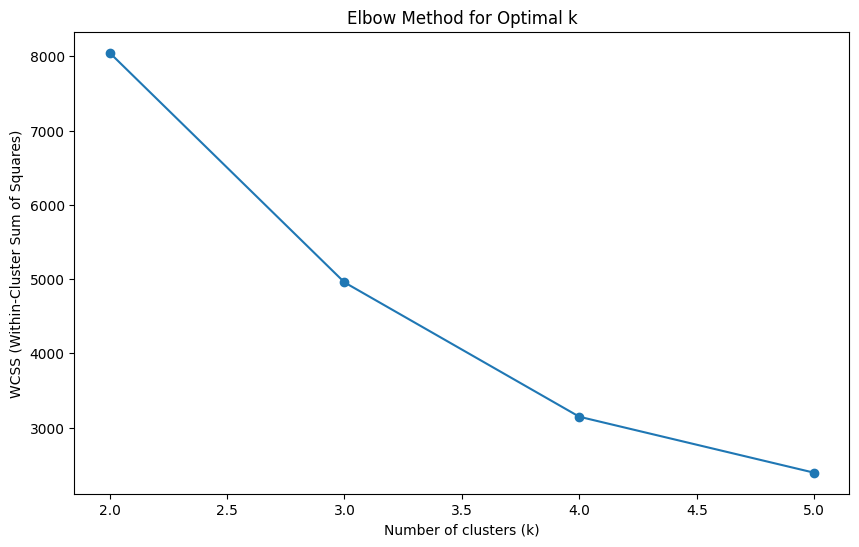

In [9]:
wcss = []

for k in range(2, 6):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data)

    wcss.append(model.summary.trainingCost)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [10]:
def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol="features", k=k, seed=1, maxIter=100, initSteps=10)
        model = kmeans.fit(data)
        predictions = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append((k, silhouette))
        print(f"k: {k}, Silhouette Score: {silhouette}")
    
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"\nOptimal k berdasarkan Silhouette Score adalah: {best_k}")
    
    return best_k, silhouette_scores

best_k, silhouette_scores = find_optimal_k(data, max_k=5)

kmeans = KMeans(featuresCol="features", k=best_k, seed=1, maxIter=100, initSteps=10)
model = kmeans.fit(data)

data = model.transform(data)

evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(data)
print(f"\nSilhouette Score untuk model dengan k={best_k}: {silhouette}")


data.groupBy("prediction").avg("level_indexed", "num_lectures", "content_duration").show()


k: 2, Silhouette Score: 0.8756782500586485
k: 3, Silhouette Score: 0.6011408999840646
k: 4, Silhouette Score: 0.6672564619876655
k: 5, Silhouette Score: 0.6579132990226071

Optimal k berdasarkan Silhouette Score adalah: 2

Silhouette Score untuk model dengan k=2: 0.8756782500586485
+----------+------------------+------------------+---------------------+
|prediction|avg(level_indexed)| avg(num_lectures)|avg(content_duration)|
+----------+------------------+------------------+---------------------+
|         1|0.2857142857142857|202.02285714285713|   24.071428571428573|
|         0|0.6383100199828718| 32.01998287182415|   3.0965267867360358|
+----------+------------------+------------------+---------------------+



In [11]:
model.save("spark_kmeans_model_c")

print("Model saved to spark_kmeans_model")

Py4JJavaError: An error occurred while calling o1137.save.
: java.io.IOException: Cannot run program "C:\Hadoop\bin\winutils.exe": CreateProcess error=216, This version of %1 is not compatible with the version of Windows you're running. Check your computer's system information and then contact the software publisher
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:934)
	at org.apache.hadoop.util.Shell.run(Shell.java:900)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1212)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1306)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1288)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.hadoop.mapred.FileOutputCommitter.setupJob(FileOutputCommitter.java:131)
	at org.apache.hadoop.mapred.OutputCommitter.setupJob(OutputCommitter.java:265)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:188)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:79)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1623)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1623)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1609)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1609)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.clustering.InternalKMeansModelWriter.write(KMeans.scala:221)
	at org.apache.spark.ml.util.GeneralMLWriter.saveImpl(ReadWrite.scala:260)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: CreateProcess error=216, This version of %1 is not compatible with the version of Windows you're running. Check your computer's system information and then contact the software publisher
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(Unknown Source)
	at java.base/java.lang.ProcessImpl.start(Unknown Source)
	... 75 more
